In [5]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
sys.path.append('..') 
import platform
import os
from pathlib import Path
import shutil
from utils.basics.data_org import curr_computer, move_subfolders
from pathlib import Path
import shutil
from utils.behavior.session_utils import load_session_df, parse_session_string
from utils.behavior.lick_analysis import clean_up_licks, parse_lick_trains
from scipy.io import loadmat
from itertools import chain
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.signal import find_peaks
from harp.clock import align_timestamps_to_anchor_points
from utils.photometry.preprocessing import *
import json
# %matplotlib inline
%matplotlib widget

In [8]:
session = 'm699461d20231222'
label = 'CombinewithKH'
session_df, licks_L, licks_R = load_session_df(session)
licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
parsed_licks_L, _ = parse_lick_trains(licks_L)
signal_region = load_session_FP(session, label)

Region mPFC recorded at channel 0
Region LCN recorded at channel 1
Region LC recorded at channel 2


In [ ]:
def load_session_FP_raw(session, label, plot=False):
    session_df, licks_L, licks_R = load_session_df(session)
    session_path = parse_session_string(session)
    file_name = f'{session}_photometry{label}.mat'
    photometry_file = os.path.join(session_path['sortedFolder'], file_name)
    photometry_json = os.path.join(session_path['photometryPath'], f'{session}.json')
    signal_mat = loadmat(photometry_file)
    with open(photometry_json, "r") as file:
        location_info = json.load(file)
    dFF = signal_mat['dFF']    
    # load photometry data and align to behavior
    signal_region = {}
    for key, value in location_info.items():
        print(f"Region {value} recorded at channel {key}")
        signal_region[value] = np.array(dFF[int(key)][0])
    signal_region['time'] = np.squeeze(np.array(signal_mat['timeFIP']))
    signal_region['time_in_beh'] = align_timestamps_to_anchor_points(
        signal_region['time'],
        np.array(signal_mat['trialStarts'][0]),
        session_df['CSon'].values
    )
    if plot:
        fig, ax = plt.subplots()
        ax.plot(signal_region['time_in_beh'], signal_region[location_info['0']], label='channel 0')
        ax2 = ax.twinx()
        ax2.hist(licks_L, bins=100, alpha=0.5, label='Licks L')
        ax2.hist(licks_R, bins=100, alpha=0.5, label='Licks R')
        ax.set_title('Alignment Check')
        plt.show()
        return signal_region, fig
    else:
        return signal_region

In [9]:
session = 'm699461d20231222'
label = 'CombinewithKH'
session_df, licks_L, licks_R = load_session_df(session)
signal_region = load_session_FP(session, label, plot=False)

Region mPFC recorded at channel 0
Region LCN recorded at channel 1
Region LC recorded at channel 2


In [45]:
# load raw recordings
import os
import numpy as np
import pandas as pd
def load_session_FP_raw(session, label, channels = ['G', 'Iso'], plot = False):
    session_dir = parse_session_string(session)
    signal_region = load_session_FP(session, label, plot=False)
    # Directory containing the files
    fpDir = session_dir['photometryPath']
    photometry_json = os.path.join(session_dir['photometryPath'], f'{session}.json')
    with open(photometry_json, "r") as file:
        location_info = json.load(file)
    # Get all files in the directory
    allFiles = os.listdir(fpDir)

    # Filter only files (ignore directories)
    allFiles = [f for f in allFiles if not os.path.isdir(os.path.join(fpDir, f))]
    time_stamps = None
    signal_region_raw = {}
    # Load signal files
    for channel in channels: 
        curr_sig = {}
        channelInd = [f for f in allFiles if f'FIP_Data{channel}' in f]
        if len(channelInd) > 0:
            channelSigData = pd.read_csv(os.path.join(fpDir, channelInd[0]), header=None).to_numpy()
            if channel == 'G':
                time_stamps = channelSigData[:, 0]
            curr_sig[channel] = channelSigData[:, 1:1 + len(location_info)]
            for key, value in location_info.items():
                print(f"Channel {channel}:Region {value} recorded at fiber {key}")
                curr_sig[value] = np.array(channelSigData[:, int(key)+1])
        signal_region_raw[channel] = curr_sig

    for color in channels:
        curr_sig = signal_region_raw[color]
        for key, value in location_info.items():
            curr_sig[value] = curr_sig[value][(time_stamps <= signal_region['time'][-1]) & (time_stamps >= signal_region['time'][0])]


    signal_region_raw['time'] = time_stamps
    signal_region_raw['time_in_beh'] = signal_region['time_in_beh']

    if plot:
        fig, ax = plt.subplots()
        ax.plot(signal_region_raw['time_in_beh'], signal_region_raw['G'][location_info['0']], label='G')
        ax2 = ax.twinx()
        ax2.hist(licks_L, bins=100, alpha=0.5, label='Licks L')
        ax2.hist(licks_R, bins=100, alpha=0.5, label='Licks R')
        ax.set_title('Alignment Check')
        plt.show()
        return signal_region_raw, fig
    else:
        return signal_region_raw




Region mPFC recorded at channel 0
Region LCN recorded at channel 1
Region LC recorded at channel 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region LCN recorded at fiber 1
Channel G:Region LC recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region LCN recorded at fiber 1
Channel Iso:Region LC recorded at fiber 2


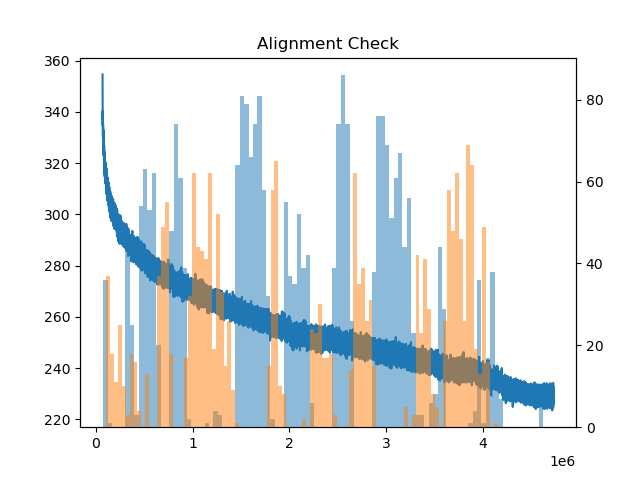

In [48]:
signal_region_raw, fig = load_session_FP_raw(session, label, channels = ['G', 'Iso'], plot = True)

In [ ]:
# denoising
curr_sig = signal_region_raw['G']['mPFC'] 

In [44]:
signal_region_raw

{'G': {'G': array([[128.10684474, 128.04794007, 128.02709568],
         [128.06677796, 128.03595506, 128.0677392 ],
         [128.13355593, 128.10786517, 128.04064352],
         ...,
         [229.56928214, 278.95131086, 136.61642676],
         [232.62771285, 276.7340824 , 136.30482642],
         [226.16360601, 282.73857678, 136.16934801]]),
  'mPFC': array([32409187.712 , 32409238.208 , 32409288.1792, ..., 37064989.6832,
         37065039.7312, 37065090.8288]),
  'LCN': array([354.63105175, 353.0951586 , 352.84140234, ..., 229.56928214,
         232.62771285, 226.16360601]),
  'LC': array([527.36479401, 518.92734082, 517.17752809, ..., 278.95131086,
         276.7340824 , 282.73857678])},
 'Iso': {'Iso': array([[128.06339144, 128.02409639, 128.09922481],
         [128.08874802, 128.10843373, 128.09922481],
         [128.07606973, 128.02409639, 128.0744186 ],
         ...,
         [156.57686212, 200.85542169, 132.41550388],
         [156.62757528, 201.25301205, 132.26666667],
        

In [27]:
len(signal_region['time_in_beh']), len(signal_region['time']), len(time_stamps), len(GSig)

(93110, 93110, 93110, 93110)